In [1]:
from __future__ import print_function

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the images

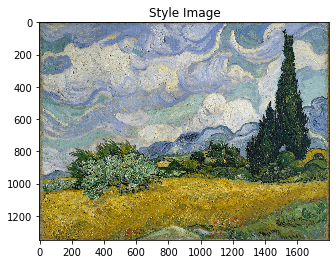

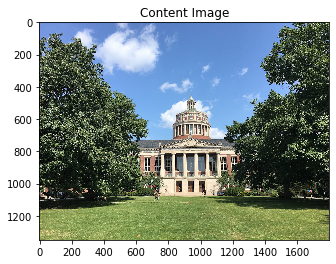

In [3]:
# Use small size if no GPU
imsize = 512 if torch.cuda.is_available() else 128  

#loader = transforms.Compose([
#    transforms.Resize(imsize),  # scale imported image
#    transforms.ToTensor()])  # transform it into a torch tensor

# if use large image, we ignore the resize clause
loader = transforms.Compose([transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("style_mid.jpeg")
content_img = image_loader("content_mid.jpeg")

assert style_img.size() == content_img.size(), "style and content images should be the same size"

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target, ):
        super(ContentLoss, self).__init__()


        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat{F_XL}

    G = torch.matmul(features, features.t())

    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Import the Model

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

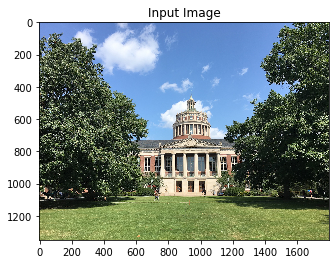

In [6]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# Create a modal to normalize input image so we can put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        # self.mean = torch.tensor(mean).view(-1, 1, 1)
        # self.std = torch.tensor(std).view(-1, 1, 1)

        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_6', 'conv_7','conv_8','conv_9', 
                        'conv_10','conv_12','conv_14','conv_16','conv_18','conv_20','conv_22']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)


    content_losses = []
    style_losses = []


    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()
# if use white noise
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure
plt.figure()
imshow(input_img, title='Input Image')

## Gradient Descent

In [7]:
def get_input_optimizer(input_img):

    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer



def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1e8, content_weight=1e-3):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [8]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)



Building the style transfer model..


RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 622080000 bytes. Error code 12 (Cannot allocate memory)


In [47]:
from torchvision.utils import save_image
save_image(output, "output_2000s8c-3.jpg")

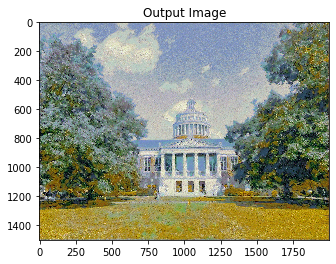

In [48]:
plt.figure()
imshow(output, title="Output Image")